## Project idea 4:
### implement and test at least 6 different variants of Isomap for DGP: the three above, and at least three new ones of your own conception

In [5]:

# The only 3 lines you need to install and use AMPL with any solver on Colab
%pip install -q amplpy
from amplpy import AMPL, ampl_notebook

P = ampl_notebook(
    modules=["highs", "gurobi"],  # modules to install (guroby is the best solver)
    license_uuid="bf5b5ed2-ea35-4373-8776-1ab021939a37",  # license to use
)  # instantiate AMPL object and register magics

Note: you may need to restart the kernel to use updated packages.
Licensed to Bundle #6415.6806 expiring 20240515: INF580 Large-scale optimization, Leo Liberti, LIX Ecole Polytechnique.


### Isomap for DGP


[(0, 1, {'weight': 7}), (0, 2, {'weight': 6}), (0, 5, {'weight': 9}), (1, 4, {'weight': 3}), (1, 5, {'weight': 10}), (1, 6, {'weight': 5}), (2, 5, {'weight': 5}), (2, 7, {'weight': 6}), (3, 6, {'weight': 7}), (3, 7, {'weight': 2}), (4, 9, {'weight': 7}), (5, 7, {'weight': 10}), (5, 8, {'weight': 9}), (5, 9, {'weight': 10}), (6, 7, {'weight': 1}), (6, 8, {'weight': 9})]


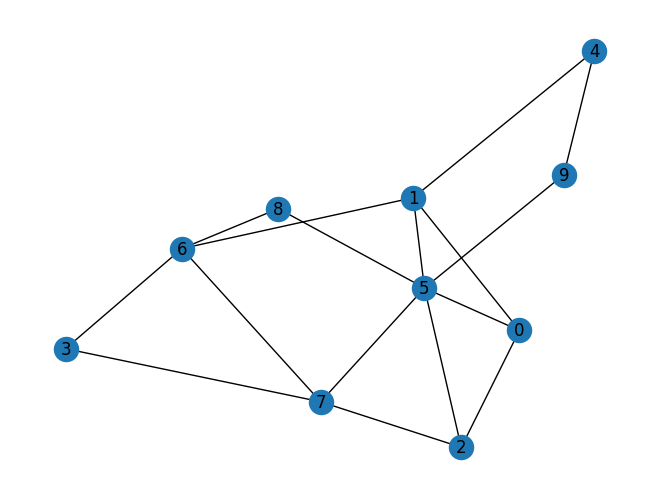

In [3]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def biconnected_graph(n):
   G = nx.gnp_random_graph(n, 0.5, directed=False)
   while(not nx.is_biconnected(G)):
         G = nx.gnp_random_graph(n, 0.5, directed=False)
   for (u, v) in G.edges():
       G[u][v]['weight'] = random.randint(1, 10)
   return G

G = biconnected_graph(10)
print(G.edges(data=True))
nx.draw(G, with_labels=True)

In [7]:
with open('biconnected_graph.dat', 'w') as f:
    f.write("# file generated by clique-instgen.run")
    f.write("\n")
    f.write("param n := %d;\n" % 50)
    f.write("set E :=")
    for (i,j) in G.edges():
        weight=G[i][j]['weight']
        f.write(" (%d,%d)" % (i,j))
    f.write(";\n")
    f.close()

In [66]:
def floyd_warshall(G):
    for i in G.nodes():
        for j in G.nodes():
            if i != j and not G.has_edge(i, j):
                G.add_edge(i, j, weight=float('inf'))
    for k in G.nodes():
        for i in G.nodes():
            for j in G.nodes():
                if i != j and i != k and j != k:
                    if G[i][j]['weight'] > G[i][k]['weight'] + G[k][j]['weight']:
                        G[i][j]['weight'] = G[i][k]['weight'] + G[k][j]['weight']

In [67]:
floyd_warshall(G)

[(0, 1, {'weight': 4}), (0, 2, {'weight': 4}), (0, 3, {'weight': 9}), (0, 4, {'weight': 4}), (0, 7, {'weight': 6}), (0, 8, {'weight': 5}), (0, 9, {'weight': 3}), (1, 2, {'weight': 8}), (1, 5, {'weight': 6}), (1, 6, {'weight': 1}), (1, 7, {'weight': 6}), (2, 8, {'weight': 3}), (3, 4, {'weight': 9}), (3, 6, {'weight': 4}), (3, 7, {'weight': 8}), (3, 9, {'weight': 4}), (4, 5, {'weight': 10}), (4, 9, {'weight': 5}), (5, 8, {'weight': 5}), (5, 9, {'weight': 6}), (6, 7, {'weight': 3}), (7, 8, {'weight': 3})]


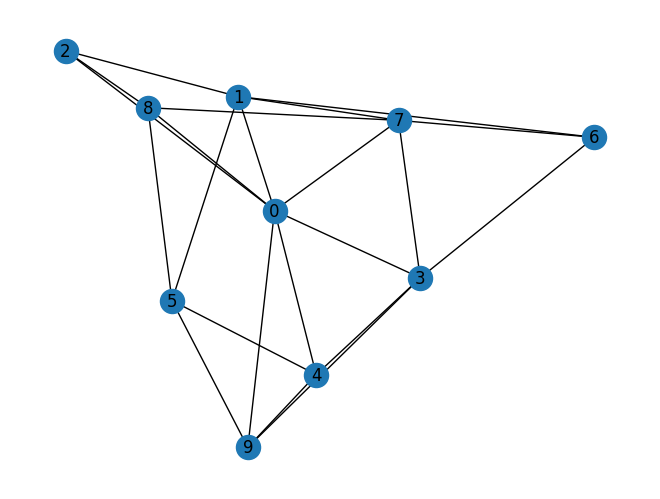

In [70]:
print(G.edges(data=True))
nx.draw(G, with_labels=True)

Code in python or ampl the runs on the terminal
Report 4/5 pages 

- Strategy
Choiche of the 6 completition algorithms:
1. Flyd_warshall -> isomap
2. Spanning Tree (STP) 
3. Push and pull (SDP)
4. Dijkstra
5. Belman Ford
6. Knn or Barvinok 

1. Let r be a vertex with highest degree in G;
2. let $x_r$ = 0;
3. let Q = {r} be a priority queue containing vertices with their degrees w.r.t. V \ Q as priority;
4. pop the vertex u with highest priority from Q;
5. for each v $\in$ $N_T(u)$ let x_v =x_u+d_{uv} and add v to Q;

In [ ]:
G1 =G.copy()
print(G1.edges(data=True))
nx.draw(G1, with_labels=True)

In [87]:

def highest_degree_vertex(G):
    """Find the vertex with the highest degree in G."""
    max_degree_node = max(G.nodes, key=G.degree)
    return max_degree_node

def sample_from_sphere(center, distance, dimension):
    """Sample a point from a sphere centered at 'center' with a given 'distance' in a space of 'dimension' dimensions."""
    realiz_sample = np.random.normal(size=dimension)
    realiz_sample /= np.linalg.norm(realiz_sample)  # Normalize to get a unit vector
    point = center + distance * realiz_sample
    return point

def BFS(G, K=3):
    """Modified BFS that samples each node's position in a K-dimensional space based on its connections."""
    root = highest_degree_vertex(G)
    positions = {root: np.zeros(K)}  # Starting at the origin for the root
    explored = {root}
    Q = [root]

    while Q:
        v = Q.pop(0)
        x_v = positions[v]

        for w in G.neighbors(v):
            if w not in explored:
                explored.add(w)
                dvw = G[v][w]['weight']
                x_w = sample_from_sphere(x_v, dvw, K)
                positions[w] = x_w
                Q.append(w)

    # Complete the graph by adding missing edges
    for u in G.nodes():
        for v in G.nodes():
            if u != v and not G.has_edge(u, v):
                # Add an edge with weight equal to the Euclidean distance between u and v
                distance = np.linalg.norm(positions[u] - positions[v])
                G.add_edge(u, v, weight=distance)

    return G, positions

def calculate_distance_matrix(positions):
    """Calculate the N x N distance matrix from the positions."""
    nodes = list(positions.keys())
    n = len(nodes)
    distance_matrix = np.zeros((n, n))

    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(positions[u] - positions[v])
            else:
                distance_matrix[i, j] = 0  # Distance to itself is 0

    return distance_matrix


In [82]:
G2, positions = BFS(G1)

In [86]:
calculate_distance_matrix(positions)

array([[ 0.        ,  9.        , 10.        ,  5.        , 10.        ,
         9.        , 10.        , 11.77262956,  5.40575436, 10.98278666],
       [ 9.        ,  0.        , 10.32033724, 12.56627684, 18.85127985,
        17.45347582,  7.55336981, 10.92919417,  9.39202589, 19.61451948],
       [10.        , 10.32033724,  0.        , 10.11598987, 17.95889691,
        14.57269923, 12.44609978,  3.        ,  5.        , 19.49694146],
       [ 5.        , 12.56627684, 10.11598987,  0.        ,  8.68914823,
         8.66648596, 11.0472395 , 12.64028541,  6.42445638, 10.34499244],
       [10.        , 18.85127985, 17.95889691,  8.68914823,  0.        ,
         6.54648388, 17.82911134, 19.93795003, 13.36777484,  2.        ],
       [ 9.        , 17.45347582, 14.57269923,  8.66648596,  6.54648388,
         0.        , 18.6528743 , 15.84546445, 10.12199003,  7.56657786],
       [10.        ,  7.55336981, 12.44609978, 11.0472395 , 17.82911134,
        18.6528743 ,  0.        , 14.51088117

[(0, 1, {'weight': 7}), (0, 2, {'weight': 6}), (0, 5, {'weight': 9}), (0, 3, {'weight': 19.614519477470907}), (0, 4, {'weight': 10.929194167723093}), (0, 6, {'weight': 9.39202588695823}), (0, 7, {'weight': 18.85127985299163}), (0, 8, {'weight': 17.453475822743687}), (0, 9, {'weight': 7.553369810199385}), (1, 4, {'weight': 3}), (1, 5, {'weight': 10}), (1, 6, {'weight': 5}), (1, 2, {'weight': 10.115989874530522}), (1, 3, {'weight': 19.496941463493492}), (1, 7, {'weight': 17.958896914497014}), (1, 8, {'weight': 14.572699233065453}), (1, 9, {'weight': 12.446099783023643}), (2, 5, {'weight': 5}), (2, 7, {'weight': 6}), (2, 3, {'weight': 10.34499244000174}), (2, 4, {'weight': 12.640285411774258}), (2, 6, {'weight': 6.4244563765536755}), (2, 8, {'weight': 8.666485957418121}), (2, 9, {'weight': 11.047239495185547}), (3, 6, {'weight': 7}), (3, 7, {'weight': 2}), (3, 4, {'weight': 21.369089594173417}), (3, 5, {'weight': 10.982786661593687}), (3, 8, {'weight': 7.566577862230943}), (3, 9, {'weight

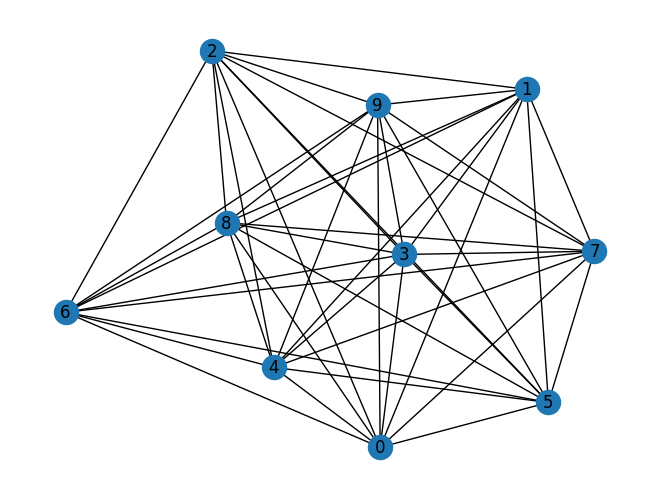

In [83]:
print(G2.edges(data=True))
nx.draw(G2, with_labels=True)

function bellmanFord(G, S)
  for each vertex V in G
    distance[V] <- infinite
      previous[V] <- NULL
  distance[S] <- 0

  for each vertex V in G				
    for each edge (U,V) in G
      tempDistance <- distance[U] + edge_weight(U, V)
      if tempDistance < distance[V]
        distance[V] <- tempDistance
        previous[V] <- U

  for each edge (U,V) in G
    If distance[U] + edge_weight(U, V) < distance[V}
      Error: Negative Cycle Exists

  return distance[], previous[]

In [92]:
import numpy as np
import networkx as nx

def bellman_ford(G):
    distances = {}
    previous = {}
    node_set = list(G.nodes())
    edge_set = G.edges()

    source_node = 0#np.random.choice(node_set)

    for v in node_set:
        distances[v] = float('inf')
        previous[v] = None
    distances[source_node] = 0

    for _ in range(len(node_set) - 1):
        for u, v in edge_set:
            weight = G[u][v]['weight']
            if distances[u] + weight < distances[v]:
                distances[v] = distances[u] + weight
                previous[v] = u

    # Check for negative-weight cycles
    for u, v in edge_set:
        weight = G[u][v]['weight']
        if distances[u] + weight < distances[v]:
            print("Error: Negative Cycle Exists")
            return None, None  
        
    #find conncetion for source node
    tmp = 0
    for u in node_set:
        if G.has_edge(source_node, u):
            tmp = G[source_node][u]['weight']
            if distances[source_node] == 0 or tmp < distances[source_node]:
                distances[source_node] = tmp 
                previous[source_node] = u


    return distances, previous


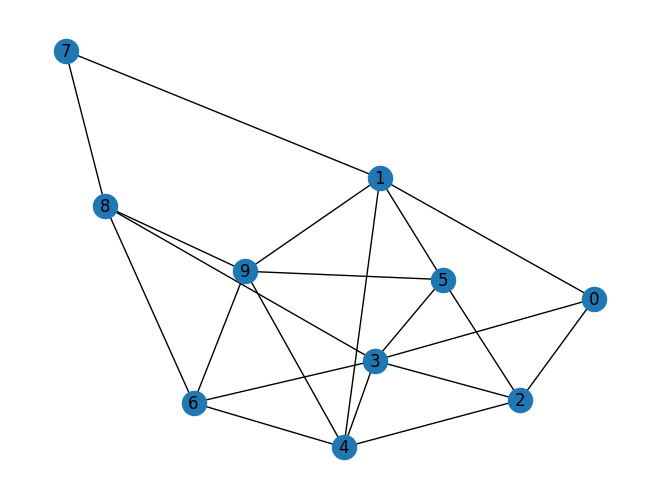

In [90]:
nx.draw(G, with_labels=True)

In [109]:
distances, previous = bellman_ford(G)

In [113]:
def build_distance_matrix(G, distances):
    n = len(G.nodes())
    d_matrix = np.full((n, n), float('inf'))
    for i in range(n):
        d_matrix[i, i] = 0
    for u in G.nodes():
        for v in G.nodes():
            if u in distances and v in distances[u]:
                d_matrix[u, v] = distances[u][v]
    return d_matrix

def build_distance_matrix(G, distances):
    n = len(G.nodes())
    node_list = list(G.nodes())
    d_matrix = np.full((n, n), float('inf')) # Initialize the matrix with infinity
    
    # Set distance from each node to itself as 0
    for i in range(n):
        d_matrix[i, i] = 0
        
    # Update distances based on the Bellman-Ford results
    for i in range(n):
        for j in range(n):
            if node_list[i] == node_list[j]:
                d_matrix[i, j] = 0
            elif node_list[j] in distances:
                d_matrix[i, j] = distances[node_list[j]]
    
    return d_matrix

In [ ]:
class ISOPredictor(nn.Module):
    def __init__(self, k_dim, h_dim):
            super(ISOPredictor, self).__init__()

            self.h1 = nn.Linear(k_dim, h_dim)
            self.out = nn.Linear(h_dim, k_dim)
            self.l_relu = nn.LeakyReLU(0.1)

    def forward(self, x):

        #state = torch.from_numpy(state).float()
        x = self.l_relu(self.h1(x))
        x = self.out(x)

        return x
    
    #write training function
    #finish distance matrix from belman ford
    #check spanning tree if it is correct

    #cmd g
    #git add .
    #git commit -m "Current load"
    #git push

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
import random as rnd
rnd.seed(42)

class ISOPredictor(nn.Module):
    def __init__(self, k_dim, h_dim):
        super(ISOPredictor, self).__init__()
        self.h1 = nn.Linear(k_dim, h_dim)
        self.out = nn.Linear(h_dim, k_dim)
        self.l_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.l_relu(self.h1(x))
        x = self.out(x)
        return x

def train(model, dataloader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        for data, target in dataloader:

            optimizer.zero_grad()  
            output = model(data)  #get the predicted isomap
            loss = loss_fn(output, target)  # Compute the loss
            loss.backward()  # Backward pass: compute the gradient
            optimizer.step()  # Update the parameters

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def infer(model, input_data):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        output = model(input_data)  # Forward pass: compute the output
    return output

#simulate network moving in a time-line, pseduo random manner
def simulate_net_moving(current_position: dict, mu: int=5, sigma:int=10): #uniform in dimension

    next_state_pos = current_position.copy()
    #random accelleration & vewlocity
    #velox_factor = rnd.gauss(15, 10)
    #apply linear translation
    for i in range(len(current_position)): #array of arrays
        velox_factor = np.random.normal(mu, sigma)
        next_state_pos[i] += np.array([velox_factor]*len(current_position[i]))

    return next_state_pos

def position_to_isomap(positions:dict):
    '''
    - compute the Isomap given the new positions, how?
    - directly compute all the distances between the nodes -> PCA -> Isomap
    '''
    nodes = list(positions.keys())
    n = len(nodes)
    distance_matrix = np.zeros((n, n))
    isomap = np.zeros((n, k))

    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(positions[u] - positions[v])
            else:
                distance_matrix[i, j] = 0  # Distance to itself is 0

    ##call PCA for isomap (use the methond in your pipeline)
    #isomap = PCA(distance_matrix, k = dim)
    return isomap


def isomap_batcher(initial_position:dict, initial_isomap:np.array(),timeline: np.array()):
    iso_batch = []
    position = initial_position
    isomap = initial_isomap
    iso_batch.append(isomap)
    for t in timeline:
        position = simulate_net_moving(current_position = position, mu=5, sigma=10)
        isomap = position_to_isomap(positions = position)
        iso_batch.append(isomap)
    
    return iso_batch


def feed_dataloader(iso_batch):
    feed_load = [(iso_batch[i], iso_batch[i+1]) i in range(len(iso_batch)-1)]
    return DataLoader(feed_load, batch_size=10, shuffle=True)

def simulate_inference(horizon: int, gt_position: dict, gt_isomap: np.array()): #gt stands for ground truth
    for _ in range(horizon):
        pred = infer(model, input_data)
        gt_position = simulate_net_moving(current_position = gt_position, mu=5, sigma=10)
        gt_isomap = position_to_isomap(positions = gt_position)

        loss = ((gt_isomap - pred)**2).mean()
        #compute mse loss
        #plot mse loss

timeline = np.arrange(0, 100, 1)
n_nodes = 10
G = biconnected_graph(n)
k_dim = 10  # Dimension of ISOMAP input/output
h_dim = 64  # Dimension of hidden layer
learning_rate = 0.001
epochs = 20

initial_position, initial_isomap = isomap_creator(G=nx.Graph())

# Initialize model, dataloader, and train
model = ISOPredictor(k_dim, h_dim)

iso_batch = isomap_batcher(initial_position, initial_isomap,timeline)
dataloader = feed_dataloader(iso_batch)

train(model, dataloader, epochs, learning_rate)

In [ ]:
##corrected version
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import random as rnd
import networkx as nx 
import matplotlib.pyplot as plt

rnd.seed(42)

class ISOPredictor(nn.Module):
    def __init__(self, k_dim, h_dim):
        super(ISOPredictor, self).__init__()
        self.h1 = nn.Linear(k_dim, h_dim)
        self.out = nn.Linear(h_dim, k_dim)
        self.l_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.l_relu(self.h1(x))
        x = self.out(x)
        return x

def train(model, dataloader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        for data, target in dataloader:
            optimizer.zero_grad()
            output = model(data.float())
            loss = loss_fn(output, target.float())
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def infer(model, input_data):
    model.eval()
    with torch.no_grad():
        output = model(input_data.float())
    return output

def simulate_net_moving(current_position, mu=5, sigma=10):
    next_state_pos = {node: pos + np.random.normal(mu, sigma, size=pos.shape) for node, pos in current_position.items()}
    return next_state_pos

def position_to_isomap(positions):
    nodes = list(positions.keys())
    n = len(nodes)
    distance_matrix = np.zeros((n, n))
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(positions[u] - positions[v])
            else:
                distance_matrix[i, j] = 0
    
    isomap = # Placeholder for PCA calculation used in the pipeline

    return isomap

def isomap_batcher(initial_position, initial_isomap, timeline):
    iso_batch = []
    position = initial_position
    isomap = initial_isomap
    iso_batch.append(torch.tensor(isomap))
    for t in timeline:
        position = simulate_net_moving(position, mu=5, sigma=10)
        isomap = position_to_isomap(position)
        iso_batch.append(torch.tensor(isomap))
    return iso_batch

def feed_dataloader(iso_batch):
    feed_load = [(iso_batch[i], iso_batch[i+1]) for i in range(len(iso_batch)-1)]
    return torch.utils.data.DataLoader(feed_load, batch_size=10, shuffle=True)


def inference(model, init_position, horizon, mu=5, sigma=10, plot_loss: bool = True):
    """
    Simulates movement based on a model and tracks the Mean Squared Error (MSE) loss over time.
    
    Parameters:
    - model: The predictive model to be used for inference.
    - init_position: The initial position to start the simulation from.
    - horizon: Number of steps to simulate.
    - mu, sigma: Parameters for the simulation of movement (mean and standard deviation).
    - plot_loss: If True, plots the evolution of the MSE loss over time.
    """

    gt_position = init_position
    gt_isomap = position_to_isomap(gt_position)
    
    mse_losses = []

    for step in range(horizon):

        isomap_tensor = torch.tensor(gt_isomap).float()

        predicted_isomap = model(infer, isomap_tensor.unsqueeze(0))  

        gt_position = simulate_net_moving(gt_position, mu, sigma)  
        
        gt_isomap = position_to_isomap(gt_position)
        
        # Calculate MSE loss.
        mse = torch.mean((predicted_isomap.squeeze() - torch.tensor(gt_isomap).float()) ** 2).item()
        mse_losses.append(mse)  
        
        print(f'Step {step+1}, MSE: {mse}')
        
    if plot_loss:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, horizon + 1), mse_losses, marker='o', linestyle='-', color='blue')
        plt.title('Evolution of MSE Loss Over Time')
        plt.xlabel('Simulation Step')
        plt.ylabel('MSE Loss')
        plt.grid(True)
        plt.show()

## Train and Test

In [ ]:
n_nodes = 10
k_dim = 10  # Dimension of ISOMAP input/output
h_dim = 64  # Dimension of hidden layer
learning_rate = 0.001
epochs = 20
timeline = np.arange(0, 1000, 1)

G = biconnected_graph(n)

initial_position, initial_isomap = #initial position needs be a dict (see BTS), initial isomap np array

iso_batch = isomap_batcher(initial_position, initial_isomap, timeline)
dataloader = feed_dataloader(iso_batch)

model = ISOPredictor(k_dim, h_dim)

train(model, dataloader, epochs, learning_rate)

In [ ]:
#inference 
horizon = 15  # Number of steps to simulate in the future
inference(model, initial_position, horizon)
